## Task:Build a 24-hour prediction model in Python 3 to provide:
### 1. Demand for the next 24 hours;
### 2. Confidence bounds with each prediction.
### 3. Capture anomalies in the time series.
#### Report on the training and validation regimes you’ve used, and any other relevant work.
#### Maximum 2 pages (including plots).

### Imports

In [684]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen

%matplotlib inline

## Exploring data

In [685]:
#read data to data frame
data = pd.read_csv('data.csv')
data.describe()

,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Total_Demand lag 0
count,102333.000000,102333.000000,102333.000000,102333.000000,102234.000000,102277.000000,87403.000000
mean,0.031896,0.029082,0.015049,0.014541,5.438484,0.066962,477.362838
std,0.175724,0.168036,0.121748,0.119706,10.619909,0.683921,167.144286
min,0.000000,0.000000,0.000000,0.000000,-29.300000,-99.000000,-3794.500185
25%,0.000000,0.000000,0.000000,0.000000,-0.900000,0.000000,377.590608
50%,0.000000,0.000000,0.000000,0.000000,5.900000,0.000000,508.842211
75%,0.000000,0.000000,0.000000,0.000000,12.800000,0.030500,578.978096
max,1.000000,1.000000,1.000000,1.000000,32.900000,6.941800,4829.563921


In [686]:
data.dtypes

DATE_TIME                      object
is_holiday                      int64
is_festival                     int64
is_regional_game_sport_1        int64
is_regional_game_sport_2        int64
temperature                   float64
previous_3_hour_max_precip    float64
Total_Demand lag 0            float64
dtype: object

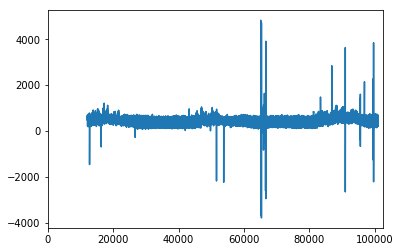

In [687]:
data['Total_Demand lag 0'].plot()

### Data Pre processing, missing values

In [688]:
def dataPreProcessing(data):
    #removing rows with no demand values 
    data = data[data['Total_Demand lag 0'].isnull() == False]
    #fill missing data with adjecent values
    data = data.fillna(method='ffill')
    #removing data for the day with incomplete data
    data = data.iloc[65:,]
    return data
    

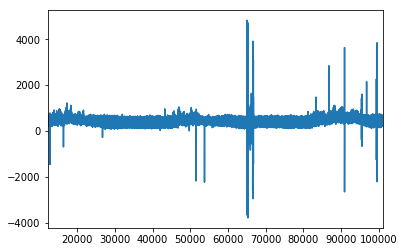

In [689]:
data = dataPreProcessing(data)
data['Total_Demand lag 0'].plot()

It looks like we have many spikes in the data indicating outliers or Anamolies. Lets examine for outliers using z - score method

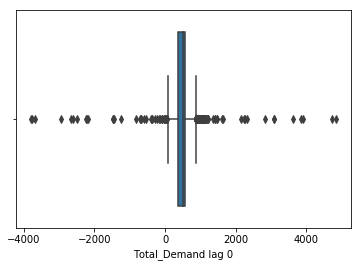

In [690]:
sns.boxplot(x=data['Total_Demand lag 0'])

## Capture anomalies in the time series and treat them

There are many outliers present in the data. Lets find them and treat them 

In [691]:
def outlierTreatment(data):
    #standardazing the demand values to check against the z-score values 
    scaler = StandardScaler()
    scaler.fit(data[['Total_Demand lag 0']])
    z_df = pd.DataFrame(scaler.transform(data[['Total_Demand lag 0']]))
    # replacing z scores with values greater that 3 and less than -3
    z_df[abs(z_df) > 3] = None
    z_df[abs(z_df) < -3] = None
    new = pd.DataFrame(scaler.inverse_transform(z_df))
    new.columns = ['Demand']
    data.reset_index(drop=True, inplace=True)
    new.reset_index(drop=True, inplace=True)
    final = pd.concat([data, new], axis = 1)
    final.drop(['Total_Demand lag 0'], axis = 1, inplace = True)
    # fill outliers values with neighbouring values
    final['Demand'] = final['Demand'].fillna(method='ffill')
    # creating date_time as index to the data frame
    final['DATE_TIME'] = pd.to_datetime(final.DATE_TIME , format = '%Y-%m-%d %H:%M')
    df = final.drop(['DATE_TIME'], axis=1)
    df.index = final.DATE_TIME
    return df

In [692]:
data = outlierTreatment(data)

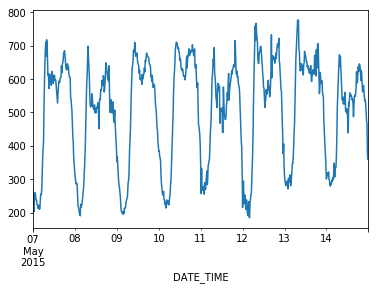

In [693]:
# Inspecting the daily trends for 8 days
data['Demand'].head(96*8).plot()

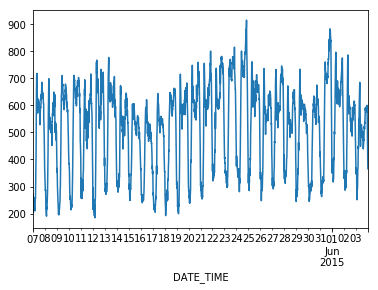

In [694]:
# Inspecting the weekly trends for 4 weeks
data['Demand'].head(96*7*4).plot()

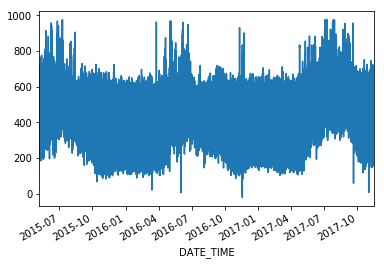

In [695]:
#plotting entire series with outlier treated data
data['Demand'].plot()

## Check for Stationarity of series using augmented Dickey–Fuller test (ADF)

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [696]:
result = adfuller(data['Demand'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.530541
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


Running the example prints the test statistic value of -24. The more negative this statistic, the more likely we are to reject the null hypothesis.
So We conclude that data is stationary.

## Check for Stationarity of series using Johansen’s test

Since we have multivariate time series, we cannot use ADF test. We have to use Johansen’s test for checking the stationarity of any multivariate time series data.

In [662]:
coint_johansen(data,-1,1).eig

array([0.12151018, 0.05175136, 0.04597908, 0.00525357, 0.00381006,
       0.00145964, 0.00054648])

For a series to be stationary, the eigenvalues should be less than 1 in modulus. The above results shows that tha series is stationary.

## Vector Auto Regression (VAR)

VAR is able to understand and use the relationship between several variables. This is useful for describing the dynamic behavior of the data and also provides better forecasting results. For using VAR model the series needs to stationary. That's why we tested and confirmed the stationarity of the data.Now we can go ahead and apply VAR.

In [663]:
#creating the train and validation set
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

#fit the model
model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/home/shreesha/anaconda3/envs/DSDJ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Model Validation with rmse

In [664]:
import math
from sklearn.metrics import mean_squared_error

#converting predictions to dataframe
cols = df.columns
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,len(cols)):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', math.sqrt(mean_squared_error(pred[i], valid[i])))

rmse value for is_holiday is :  0.19255159759145254
rmse value for is_festival is :  0.22909526487513024
rmse value for is_regional_game_sport_1 is :  0.09515993312854396
rmse value for is_regional_game_sport_2 is :  0.08059444913345218
rmse value for temperature is :  11.423351014526231
rmse value for previous_3_hour_max_precip is :  0.25271140474571613
rmse value for Demand is :  176.57951660052717


## Forecast for next 24 hours water demand with 15 minutes interval

In [665]:
#make final predictions
model = VAR(endog=df)
model_fit = model.fit()
steps = 24*4
yhat = model_fit.forecast_interval(model_fit.y, steps=steps)
# pred = pd.DataFrame(index=range(0,len(yhat)),columns=[cols])
# pred['Total_Demand lag 0']
pred = []
for i in range(0, steps):
    tup = []
    for val in yhat:
        tup.append(val[i][6]) 
    pred.append(tup)
pred = pd.DataFrame(pred)
pred.columns = ['point estimate', '95% CI Lower bound', '95% CI upperbound']

/home/shreesha/anaconda3/envs/DSDJ/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## forecast with 95% Confidence Interval

In [666]:
pred.head() #showing only first five values to save space

,point estimate,95% CI Lower bound,95% CI upperbound
0,546.566547,492.225027,600.908067
1,546.039616,469.759461,622.319771
2,545.478977,452.740916,638.217039
3,544.888913,438.582714,651.195112
4,544.273298,426.276415,662.270180


## Plotting the forecasts

In [667]:
final.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
graph = pd.concat([final[['Demand']],pred], axis = 0)

/home/shreesha/anaconda3/envs/DSDJ/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


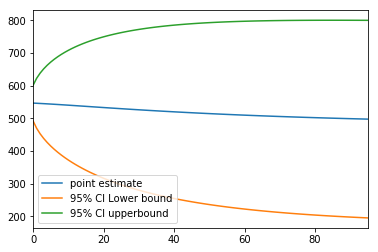

In [668]:
pred.plot()

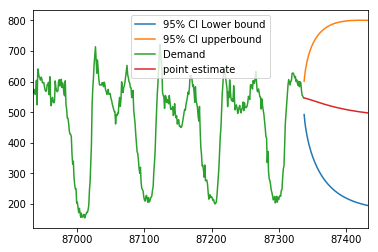

In [669]:
graph.reset_index(drop=True, inplace=True)
graph.tail(500).plot()

## Saving the forecast to a csv file

In [670]:
pred.to_csv('forecast.csv',index=False)

## Anomalies Detection using IQR - Inter Quartile Range

Looking at the data we are pretty sure that there are no outliers in them. So we examine for the water demand data only

In [671]:
def detectAnomalies(data, field):
    data.columns = ['DATE_TIME', 'is_holiday', 'is_festival', 'is_regional_game_sport_1',
       'is_regional_game_sport_2', 'temperature', 'previous_3_hour_max_precip',
       'Demand']
    Q1 = data[field].quantile(0.25)
    Q3 = data[field].quantile(0.75)
    IQR = Q3 - Q1
    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    fil = data[[field]]
    anomalies_suspected =  data[(fil[field] < Q1-1.5 * IQR) | (fil[field] > Q3+1.5*IQR) ]
    # Filtering Values between Q1-3IQR and Q3+3IQR
    anomalies =  data[(fil[field] < Q1-3 * IQR) | (fil[field] > Q3+3*IQR) ]
    return anomalies_suspected, anomalies

In [672]:
data = pd.read_csv('data.csv')
data = dataPreProcessing(data)
anomalies_suspected, anomalies = detectAnomalies(data, 'Demand')

### Anomalies for Water Demand

In [673]:
anomalies

,DATE_TIME,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Demand
12791,2015-05-13 7:45,0,0,0,0,-1.8,0.0864,-1466.144477
12792,2015-05-13 8:00,0,0,0,0,-1.9,0.0864,-1448.482223
16365,2015-06-19 13:15,0,0,0,0,17.3,0.1270,-698.220547
17260,2015-06-28 21:00,0,0,0,0,29.3,0.0000,1204.637759
17262,2015-06-28 21:30,0,0,0,0,28.7,0.0000,1210.369030
26727,2015-10-05 11:45,0,0,0,0,4.5,0.0000,-280.388372
51596,2016-06-20 13:00,0,0,0,0,19.1,0.0000,-2182.216267
53795,2016-07-13 10:45,0,1,0,0,12.8,0.3835,-2238.163257
65119,2016-11-08 9:45,0,0,0,0,11.0,0.0000,-3676.560916
65121,2016-11-08 10:15,0,0,0,0,11.0,0.0000,4829.563921


### Anomalies For Temperature

In [674]:
anomalies_suspected, anomalies = detectAnomalies(data, 'temperature')

In [675]:
anomalies # Temperature

,DATE_TIME,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Demand


#### No anomalies for Temperature

### Anomalies For previous_3_hour_max_precip

In [676]:
anomalies_suspected, anomalies = detectAnomalies(data, 'previous_3_hour_max_precip')

In [677]:
anomalies #previous_3_hour_max_precip

,DATE_TIME,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Demand
12280,2015-05-08 0:00,0,0,0,0,3.3,0.3404,310.653189
12281,2015-05-08 0:15,0,0,0,0,3.1,0.3404,301.312786
12282,2015-05-08 0:30,0,0,0,0,2.8,0.3404,289.440649
12283,2015-05-08 0:45,0,0,0,0,2.6,0.3404,285.003884
12284,2015-05-08 1:00,0,0,0,0,2.3,0.5461,287.938092
12285,2015-05-08 1:15,0,0,0,0,2.1,0.5461,282.121266
12286,2015-05-08 1:30,0,0,0,0,1.8,0.5461,249.810722
12287,2015-05-08 1:45,0,0,0,0,1.5,0.5461,218.263592
12288,2015-05-08 2:00,0,0,0,0,1.3,0.5461,215.960102
12289,2015-05-08 2:15,0,0,0,0,1.3,0.5461,207.308289


In [678]:
anomalies.shape

(9326, 8)

### Since we found 9326 outliers we can't consider them as the outliers. So We won't treat them or remove them.

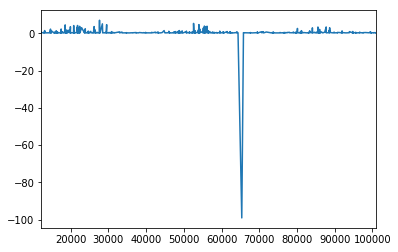

In [679]:
anomalies['previous_3_hour_max_precip'].plot()

#### Among these data points one point looks sure shot outlier. So we will remove it and replace it with previous value.

In [681]:
data[data['previous_3_hour_max_precip'] == -99.0] = None
data.fillna(method='ffill')

,DATE_TIME,is_holiday,is_festival,is_regional_game_sport_1,is_regional_game_sport_2,temperature,previous_3_hour_max_precip,Demand
12184,2015-05-07 0:00,0.0,0.0,0.0,0.0,1.2,0.0356,271.987641
12185,2015-05-07 0:15,0.0,0.0,0.0,0.0,1.0,0.0356,237.828319
12186,2015-05-07 0:30,0.0,0.0,0.0,0.0,0.9,0.0356,202.813658
12187,2015-05-07 0:45,0.0,0.0,0.0,0.0,0.8,0.0356,233.749718
12188,2015-05-07 1:00,0.0,0.0,0.0,0.0,0.7,0.0178,248.291042
12189,2015-05-07 1:15,0.0,0.0,0.0,0.0,0.5,0.0178,260.082887
12190,2015-05-07 1:30,0.0,0.0,0.0,0.0,0.4,0.0178,245.253273
12191,2015-05-07 1:45,0.0,0.0,0.0,0.0,0.2,0.0178,240.622878
12192,2015-05-07 2:00,0.0,0.0,0.0,0.0,0.1,0.0254,235.992484
12193,2015-05-07 2:15,0.0,0.0,0.0,0.0,-0.2,0.0254,224.447964


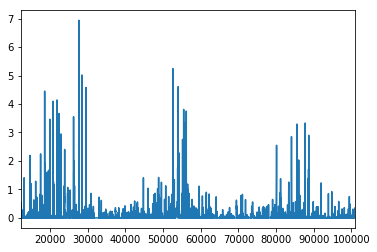

In [682]:
data['previous_3_hour_max_precip'].plot()